<a href="https://colab.research.google.com/github/eneskacan/agu-capstone/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Define external URLs
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/eneskacan/agu-capstone/main/"
VEHICLES_DATA = DOWNLOAD_ROOT + "dataset/class_5.csv"

In [23]:
# Import dataset (class_5.csv)
import pandas as pd

X_df = pd.read_csv(VEHICLES_DATA, header=None).iloc[: , :-1] # drop the last column
y_df = pd.read_csv(VEHICLES_DATA, header=None).iloc[: , -1:] # pick the last column

vehicle_df = pd.concat([X_df, y_df], axis=1)

pd.set_option("display.max_columns", 15) # limit max number of columns displayed
vehicle_df.head()

,0,1,2,3,4,5,6,...,615,616,617,618,619,620,621
0,-4646,-4635,-4621,-4622,-4637,-4689,-4789,...,0,0,0,0,0,0,hatchback
1,-4500,-4551,-4581,-4529,-4514,-4564,-4616,...,0,0,0,0,0,0,hatchback
2,-4333,-4326,-4329,-4329,-4327,-4331,-4325,...,0,0,0,0,0,0,hatchback
3,-4308,-4304,-4300,-4302,-4293,-4284,-4270,...,0,0,0,0,0,0,hatchback
4,-4765,-4763,-4766,-4757,-4758,-4754,-4755,...,0,0,0,0,0,0,hatchback


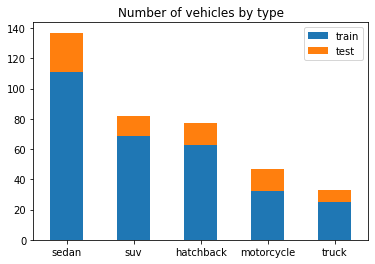

In [19]:
# Split dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2)

# Count vehicle types
count_train = y_train.apply(pd.value_counts).rename(columns={y_train.columns[0]:'train'}).T
count_test = y_test.apply(pd.value_counts).rename(columns={y_test.columns[0]:'test'}).T

# Plot stacked bar chart
pd.DataFrame([['sedan', count_train[['sedan']].values[0][0], count_test[['sedan']].values[0][0]], 
              ['suv', count_train[['suv']].values[0][0], count_test[['suv']].values[0][0]],
              ['hatchback', count_train[['hatchback']].values[0][0], count_test[['hatchback']].values[0][0]],
              ['motorcycle', count_train[['motorcycle']].values[0][0], count_test[['motorcycle']].values[0][0]],
              ['truck', count_train[['truck']].values[0][0], count_test[['truck']].values[0][0]]],
             columns=['', 'train', 'test']).plot(x='', kind='bar', stacked=True,
                                                 title='Number of vehicles by type', rot=0);